# Phase/Orientation Mapping

This tutorial demonstrates how to achieve phase and orientation mapping via scanning electron diffraction using both pattern and vector matching.

The data was acquired from a GaAs nanowire displaying polymorphism between zinc blende and wurtzite structures.

This functionaility has been checked to run in pyxem-0.15.0 (April 2023). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

1. <a href='#loa'> Load & Inspect Data</a>
2. <a href='#pre'> Pre-processing</a>
3. <a href='#tem'> Template matching</a>
    1. <a href='#tema'> [Build Template Library]</a>
    2. <a href='#temb'>[Indexing]</a>
4. <a href='#vec'> Vector Matching</a>
    1. <a href='#veca'> [Build Vector Library]</a>
    2. <a href='#vecb'>[Indexing Vectors]</a>

Import pyxem and other required libraries

In [1]:
%matplotlib inline

import numpy as np
import diffpy.structure
import pyxem as pxm
import hyperspy.api as hs
import hyperspy
accelarating_voltage = 200  # kV
camera_length = 0.2  # m
diffraction_calibration = 0.032  # px / Angstrom

print(pxm.__version__)
print(hyperspy.__version__)

0.15.0
1.7.4


<a id='loa'></a>

##  1. Loading and Inspection

Load the demo data

In [2]:
dp = hs.load('./data/02/polymorphic_nanowire.hdf5', reader="hspy")
dp

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


<ElectronDiffraction2D, title: GaAs NW (110 zone), dimensions: (20, 45|144, 144)>

Set data type, scale intensity range and set calibration

In [3]:
dp.data = dp.data.astype('float64')
dp.data *= 1 / dp.data.max()

Inspect metadata

In [4]:
dp.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Diffraction
│       │       ├── camera_length = 10.0
│       │       └── exposure_time = 10.0
│       ├── rocking_angle = 12.217304763960307
│       ├── rocking_frequency = 100.0
│       └── scan_rotation = 1.0
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 1.7.4
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-04-02T13:13:02.055851-05:00
│   └── title = GaAs NW (110 zone)
└── Signal
    └── signal_type = electron_diffraction

Plot an interactive virtual image to inspect data

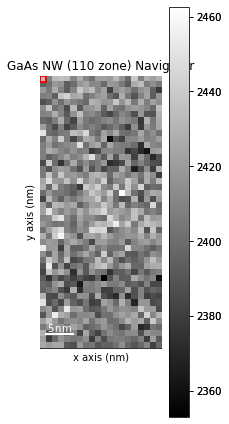

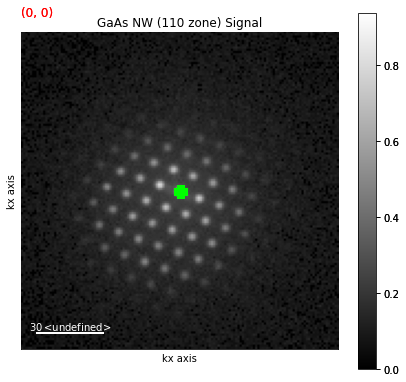

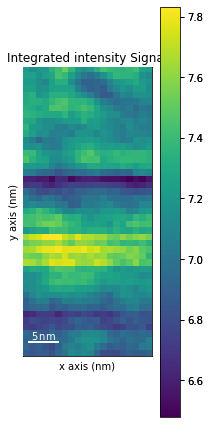

In [5]:
roi = hs.roi.CircleROI(cx=72, cy=72, r_inner=0, r=2)
dp.plot_integrated_intensity(roi=roi, cmap='viridis')

<a id='pre'></a>

##  2. Pre-processing

Apply affine transformation to correct for off axis camera geometry

In [6]:
scale_x = 0.995
scale_y = 1.031
offset_x = 0.631
offset_y = -0.351
dp.apply_affine_transformation(np.array([[scale_x, 0, offset_x],
                                         [0, scale_y, offset_y],
                                         [0, 0, 1]]))

[########################################] | 100% Completed |  0.2s


Perform difference of gaussian background subtraction with various parameters on one selected diffraction pattern and plot to identify good parameters

In [7]:
from pyxem.utils.expt_utils import investigate_dog_background_removal_interactive

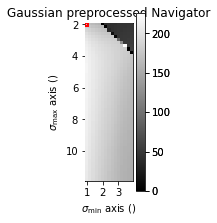

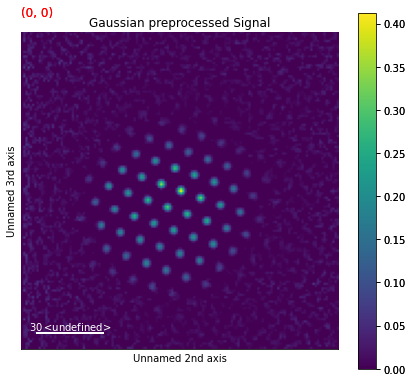

In [8]:
dp_test_area = dp.inav[0, 0]

gauss_stddev_maxs = np.arange(2, 12, 0.2) # min, max, step
gauss_stddev_mins = np.arange(1, 4, 0.2) # min, max, step

investigate_dog_background_removal_interactive(dp_test_area,
                                               gauss_stddev_maxs,
                                               gauss_stddev_mins)

Remove background using difference of gaussians method with parameters identified above

In [9]:
dp = dp.subtract_diffraction_background('difference of gaussians',
                          min_sigma=2, max_sigma=8,
                          lazy_result=False)

[########################################] | 100% Completed |  0.3s


Perform further adjustments to the data ranges

In [10]:
dp.data -= dp.data.min()
dp.data *= 1 / dp.data.max()

Set diffraction calibration and scan calibration

In [11]:
dp = pxm.signals.ElectronDiffraction2D(dp) #this is needed because of a bug in the code
dp.set_diffraction_calibration(diffraction_calibration)
dp.set_scan_calibration(10)

<a id='tem'></a>

##  3. Pattern Matching

Pattern matching generates a database of simulated diffraction patterns and then compares all simulated patterns against each experimental pattern to find the best match

Import generators required for simulation and indexation

In [12]:
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.generators.library_generator import DiffractionLibraryGenerator

from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction
from diffsims.generators.rotation_list_generators import get_grid_around_beam_direction

from pyxem.generators.indexation_generator import AcceleratedIndexationGenerator

### 3.1. Define Library of Structures & Orientations

Define the crystal phases to be included in the simulated library

In [13]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
resolution = 1.5 # maximum angle in degrees between nearest templates. Pretty rough grid for speed.
grid_cube = get_beam_directions_grid("cubic", resolution, mesh="spherified_cube_edge")
grid_hex = get_beam_directions_grid("hexagonal", resolution, mesh="spherified_cube_edge")

print("Number of patterns: ", grid_cube.shape[0])

Number of patterns:  496


/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/diffsims/generators/sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


(-0.1, 0.5)

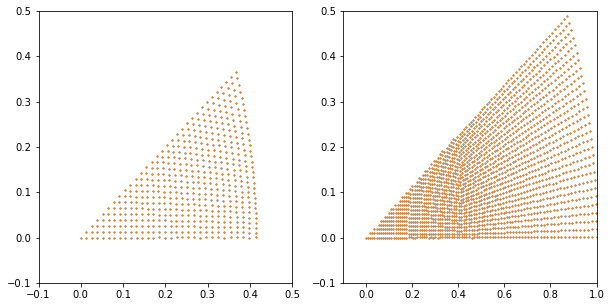

In [14]:
import matplotlib.pyplot as plt
# this cell serves to visualize the grid of orientations in stereographic projection

# a helper function for turning the euler angle grid to a grid of points in the stereographic projection
def grid_to_xy(grid):
    from orix.quaternion.rotation import Rotation
    from orix.vector.vector3d import Vector3d
    from orix.projections import StereographicProjection
    s = StereographicProjection(pole=-1)
    rotations_regular =  Rotation.from_euler(np.deg2rad(grid))
    rot_reg_test = rotations_regular*Vector3d.zvector()
    x, y = s.vector2xy(rot_reg_test)
    return x, y

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].scatter(*grid_to_xy(grid_cube), s = 1)
axs[0].set_xlim(-0.1, 0.5)
axs[0].set_ylim(-0.1, 0.5)
axs[0].scatter(*grid_to_xy(grid_cube), s = 1)
axs[0].set_xlim(-0.1, 0.5)
axs[0].set_ylim(-0.1, 0.5)

axs[1].scatter(*grid_to_xy(grid_hex), s = 1)
axs[1].set_xlim(-0.1, 0.5)
axs[1].set_ylim(-0.1, 0.5)
axs[1].scatter(*grid_to_xy(grid_hex), s = 1)
axs[1].set_xlim(-0.1, 1)
axs[1].set_ylim(-0.1, 0.5)

In [15]:
# Parameters necessary for simulating a template library
# half size of the images
half_shape = (dp.data.shape[-2]//2, dp.data.shape[-1]//2)
# maximum radius in reciprocal space to calculate spot intensities for
reciprocal_radius = np.sqrt(half_shape[0]**2 + half_shape[1]**2)*diffraction_calibration

In [16]:
structure_zb = diffpy.structure.loadStructure('./data/02/GaAs_mp-2534_conventional_standard.cif')
structure_wz = diffpy.structure.loadStructure('./data/02/GaAs_mp-8883_conventional_standard.cif')

Create a basic rotations list.    

In [17]:
diff_gen = DiffractionGenerator(accelerating_voltage=200,
                                precession_angle=0,
                                scattering_params=None,
                                shape_factor_model="linear",
                                minimum_intensity=0.1,
                                )

In [18]:
za110c = get_rotation_from_z_to_direction(structure_zb, [1,1,0])
rot_list_cubic = get_grid_around_beam_direction(beam_rotation=za110c, resolution=1, angular_range=(0,180))

In [19]:
za110h = get_rotation_from_z_to_direction(structure_wz, [1,1,0])
rot_list_hex = get_grid_around_beam_direction(beam_rotation=za110h, resolution=1, angular_range=(0,180))

Construct a StructureLibrary defining crystal structures and orientations for which diffraction will be simulated 

In [20]:
struc_lib = StructureLibrary(['ZB','WZ'],
                             [structure_zb,structure_wz],
                             [grid_cube,grid_hex])

<a id='temb'></a>
###  3.2. Simulate Diffraction for all Structures & Orientations

Define a diffsims DiffractionGenerator with diffraction simulation parameters

In [21]:
diff_gen = DiffractionGenerator(accelerating_voltage=accelarating_voltage)

Initialize a diffsims DiffractionLibraryGenerator

In [22]:
lib_gen = DiffractionLibraryGenerator(diff_gen)

Calulate library of diffraction patterns for all phases and unique orientations

In [23]:
target_pattern_dimension_pixels = dp.axes_manager.signal_shape[0]
half_size = target_pattern_dimension_pixels // 2
reciprocal_radius = diffraction_calibration*(half_size - 1)

diff_lib = lib_gen.get_diffraction_library(struc_lib,
                                           calibration=diffraction_calibration,
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=(half_size, half_size),
                                           max_excitation_error=1/10,
                                           with_direct_beam=False)

Optionally, save the library for later use.

In [24]:
#diff_lib.pickle_library('./GaAs_cubic_hex.pickle')

If saved, the library can be loaded as follows

In [25]:
#from diffsims.libraries.diffraction_library import load_DiffractionLibrary
#diff_lib = load_DiffractionLibrary('./GaAs_cubic_hex.pickle', safety=True)

<a id='temb'></a>
###  3.3. Pattern Matching Indexation

Initialize `AcceleratedIndexationGenerator` with the experimental data and diffraction library and perform correlation, returning the `n_largest` matches with highest correlation.

This workflow is explained in more detail using example notebook 11.  For a more in depth explination of how this works go there!

<div class="alert alert-block alert-warning"><b>Note:</b> This workflow has been changed from previous version, make sure you have pyxem 0.15.0 or later installed</div>

In [26]:
indexer = AcceleratedIndexationGenerator(dp, diff_lib)
result, phasedict = indexer.correlate(n_largest=3)

[########################################] | 100% Completed |  1min 16.7s


In [27]:
list(phasedict.keys())

[0, 1]

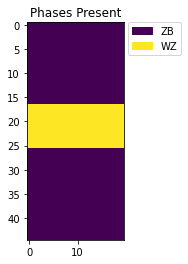

In [28]:
# Plottig the phase with the largest correlation. 
import matplotlib.patches as mpatches
plt.figure()
im = plt.imshow(result["phase_index"][:,:,0])
values = list(phasedict.keys())
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=phasedict[i].format(l=values[i]) ) for i in range(len(values)) ]
plt.title("Phases Present")
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

Get crystallographic map from indexation results

##  4. Vector Matching

<div class="alert alert-block alert-danger"><b>Note:</b> This workflow is less well developed than the template matching one.  Look for an improved method coming with version 1.0.0.  For now it is highly recommended that you use the above Accelerated template matching!</div>